In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, norm, uniform


from wpca.distribution import PeriodicDistribution
from wpca.transport import PeriodicTransportMap

In [2]:
xgrid = np.linspace(0.0001, 0.9999, 1000)
p1_func = lambda x: uniform.cdf(x, 1/4, 1/8)

In [3]:
dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p1_func(xgrid))

Text(0.5, 1.0, 'Circular Quantile')

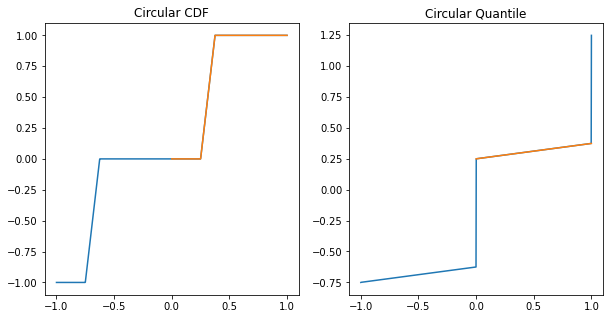

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

extended_grid = np.linspace(-1, 1, 1000)
theta = 0.0
axes[0].plot(extended_grid, dist.periodic_cdf(theta, extended_grid))
axes[0].plot(xgrid, dist.cdf(xgrid))
axes[1].plot(extended_grid, dist.periodic_quantile(theta, extended_grid))
axes[1].plot(xgrid, dist.quantile(xgrid))

axes[0].set_title("Circular CDF")
axes[1].set_title("Circular Quantile")

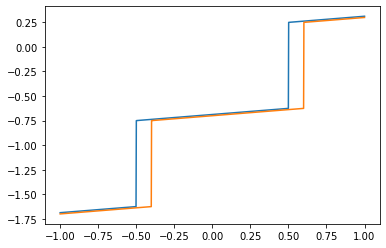

In [5]:
theta = np.array([0.5, 0.6])
qq = dist.periodic_quantile(theta, extended_grid)

plt.plot(extended_grid, qq[0, :])
plt.plot(extended_grid, qq[1, :])

In [6]:
a = np.linspace(-1, 1, 3)
b = np.linspace(5, 1, 5)

c = a[:, np.newaxis] - b[np.newaxis, :]
c

array([[-6., -5., -4., -3., -2.],
       [-5., -4., -3., -2., -1.],
       [-4., -3., -2., -1.,  0.]])

In [7]:
# Transport
xgrid = np.linspace(0.0001, 0.9999, 1000)
p1_func = lambda x: uniform.cdf(x, 3/4, 1/8)
d1 = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p1_func(xgrid))

p2_func = lambda x: uniform.cdf(x, 3/4, 1/3)
d2 = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p2_func(xgrid))

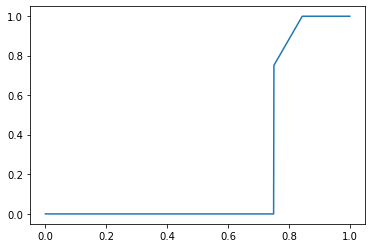

In [8]:
transport = PeriodicTransportMap(d1)
transport.compute(d2)

plt.plot(xgrid, transport(xgrid))

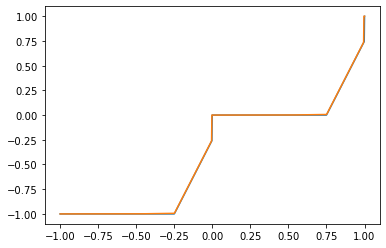

In [9]:
out_meas = transport.get_pushforward_measure()
plt.plot(extended_grid, d2.periodic_cdf(0, extended_grid))
plt.plot(extended_grid, out_meas.periodic_cdf(0, extended_grid))

# Procrustes Analysis

In [10]:
from wpca.barycenter import ProcrustesBarycenter, SinkhornBarycenter

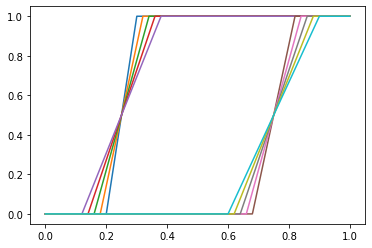

In [11]:
measures = []

for i in range(10):
    if i < 5:
        c = 1/4
        w = 0.1 + 0.2 / 5 * i
    else:
        c= 3/4
        w = 0.1 + 0.2 / 5 * (i - 4)
    p_func = lambda x: uniform.cdf(x, c - w/2, w)
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p_func(xgrid))
    measures.append(dist)
    plt.plot(xgrid, p_func(xgrid))

In [12]:
bary_w = ProcrustesBarycenter(threshold=1e-3)
bary_w.compute(measures)

0.01315098384738585
0.0005828800466474456


In [13]:
bary_s = SinkhornBarycenter(xgrid, threshold=1e-4, max_iter=2000)
bary_s.compute(measures)

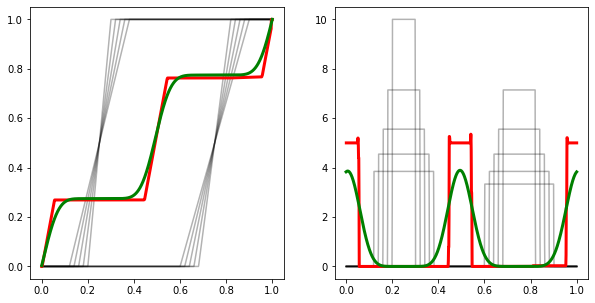

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

cdf = bary_w.bary_measure.cdf(xgrid)
pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
pdf[-20:] = pdf[-20]
pdf[:20] = pdf[20]
axes[0].plot(xgrid, cdf, color="red", lw=3)
axes[1].plot(xgrid[1:], pdf, color="red", lw=3)

pdf = bary_s.barycenter_pmf / (xgrid[1] - xgrid[0])
cdf = np.cumsum(pdf) * (xgrid[1] - xgrid[0])
axes[0].plot(xgrid, cdf, color="green", lw=3)
axes[1].plot(xgrid, pdf, color="green", lw=3)

# plt.savefig("wass_vs_sinkh_bary.pdf", bbox_inches="tight")

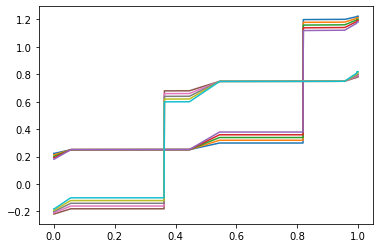

In [15]:
transports = []
t_evals = []

for m in measures:
    t = PeriodicTransportMap(bary_w.bary_measure)
    t.compute(m)
    transports.append(t)
    t_evals.append(t(xgrid))
    plt.plot(xgrid, t(xgrid))
    
t_evals = np.array(t_evals)

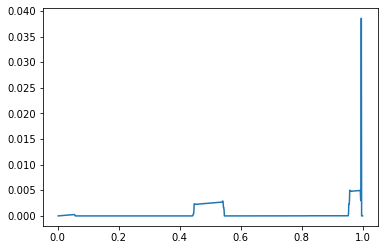

In [16]:
plt.plot(xgrid[1:], np.mean(t_evals, axis=0)[1:] * np.diff(bary_w.bary_measure.cdf(xgrid)))

In [17]:
bary = procrustes_iter(bary, measures)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf)
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

cdf = bary.cdf(xgrid)
pdf = np.diff(cdf)
axes[0].plot(xgrid, cdf, color="red", lw=3)
axes[1].plot(xgrid[1:], pdf, color="red", lw=3)

NameError: name 'procrustes_iter' is not defined

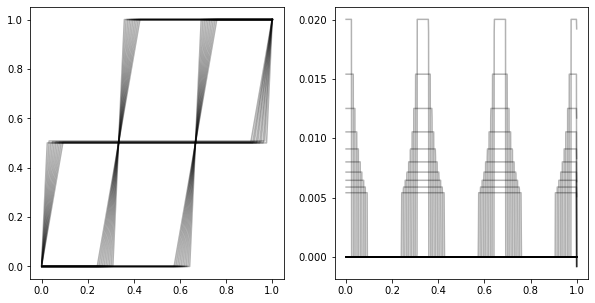

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


measures = []
centers = [0, 1/3, 2/3]

for i in range(10):
    w = 0.05 + 0.15 / 10 * i
    pdf = np.zeros_like(xgrid) 
    pdf[((xgrid <= w/2) | (xgrid >= 1 - w/2))] = 1 / w
    cdf = np.cumsum(pdf) * (xgrid[1] - xgrid[0])
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=cdf)
    measures.append(dist)
    

for i in range(20):
    if i < 10:
        c = centers[1]
        w = 0.05 + 0.15 / 10 * i
    else:
        c = centers[2]
        w = 0.05 + 0.15 / 10 * (i - 10)
        
    p_func = lambda x: uniform.cdf(x, c - w/2, w)
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p_func(xgrid))
    measures.append(dist)
    
    
for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf)
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

In [19]:
bary = PeriodicDistribution(supp_grid=xgrid, cdf_eval=xgrid)

In [20]:
bary = procrustes_iter(bary, measures)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf)
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

cdf = bary.cdf(xgrid)
pdf = np.diff(cdf)
axes[0].plot(xgrid, cdf, color="red", lw=3)
axes[1].plot(xgrid[:-2], pdf[:-1], color="red", lw=3)

NameError: name 'procrustes_iter' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


measures = []
centers = [0, 1/4, 1/2, 3/4]

for i in range(10):
    w = 0.05 + 0.15 / 10 * i
    pdf = np.zeros_like(xgrid) 
    pdf[((xgrid <= w/2) | (xgrid >= 1 - w/2))] = 1 / w
    cdf = np.cumsum(pdf) * (xgrid[1] - xgrid[0])
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=cdf)
    measures.append(dist)
    

for i in range(30):
    if i < 10:
        c = centers[1]
        w = 0.05 + 0.15 / 10 * i
    elif i < 20:
        c = centers[2]
        w = 0.05 + 0.15 / 10 * (i - 10)
    else:
        c = centers[3]
        w = 0.05 + 0.15 / 10 * (i - 20)
        
    p_func = lambda x: uniform.cdf(x, c - w/2, w)
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=p_func(xgrid))
    measures.append(dist)
    
    
for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf)
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

In [ ]:
bary = PeriodicDistribution(supp_grid=xgrid, cdf_eval=xgrid)

In [ ]:
bary, dist = procrustes_iter(bary, measures)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

cdf = bary.cdf(xgrid)
pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
axes[0].plot(xgrid, cdf, color="red", lw=3)
axes[1].plot(xgrid[:-2], pdf[:-1], color="red", lw=3)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
theta = 2 * np.pi * xgrid

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    ax.plot(theta[1:], 20 - pdf, color="black", alpha=0.3)
    
    
ext_grid = np.linspace(-1, 2, 3000)
cdf = bary.periodic_cdf(0, ext_grid)
cdf_spline = UnivariateSpline(ext_grid, cdf, s=0.005)
pdf = cdf_spline.derivative()
axes[0].plot(xgrid, cdf_spline(xgrid), color="red", lw=3)
axes[1].plot(xgrid, pdf(xgrid), color="red", lw=3)
    
ax.plot(theta, 20 - pdf(xgrid), color="red", lw=3)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.cos(theta)
y = np.sin(theta)

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    ax.plot(x[1:], y[1:], pdf, color="black", alpha=0.3)

ext_grid = np.linspace(-1, 2, 3000)
cdf = bary.periodic_cdf(0, ext_grid)
cdf_spline = UnivariateSpline(ext_grid, cdf, s=0.005)
pdf = cdf_spline.derivative()
axes[0].plot(xgrid, cdf_spline(xgrid), color="red", lw=3)
axes[1].plot(xgrid, pdf(xgrid), color="red", lw=3)
    
ax.plot(x, y, pdf(xgrid), color="red", lw=3)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


measures = []

for i in range(20):
    b = 2
    if i < 10:
        a = np.random.uniform(1.1, 1.5)
    else:
        a = np.random.uniform(2.2, 3)
    pfunc = lambda x: beta.cdf(x, a, b)
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=pfunc(xgrid))
    measures.append(dist)
    
    
for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf)
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

In [ ]:
bary = PeriodicDistribution(supp_grid=xgrid, cdf_eval=xgrid)

In [ ]:
for i in range(100):
    new_bary, dist = procrustes_iter(bary, measures)
    print(dist)
    if (dist < 1e-5):
        break
    bary = new_bary

In [ ]:
dist

In [ ]:
from scipy.interpolate import UnivariateSpline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    axes[0].plot(xgrid, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:], pdf, color="black", alpha=0.3)

ext_grid = np.linspace(-1, 2, 3000)
cdf = bary.periodic_cdf(0, ext_grid)
cdf_spline = UnivariateSpline(ext_grid, cdf, s=0.005)
pdf = cdf_spline.derivative()
axes[0].plot(xgrid, cdf_spline(xgrid), color="red", lw=3)
axes[1].plot(xgrid, pdf(xgrid), color="red", lw=3)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
theta = 2 * np.pi * xgrid

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    ax.plot(theta[1:], 1.75 - pdf, color="black", alpha=0.3)
    
    
ext_grid = np.linspace(-1, 2, 3000)
cdf = bary.periodic_cdf(0, ext_grid)
cdf_spline = UnivariateSpline(ext_grid, cdf, s=0.005)
pdf = cdf_spline.derivative()
    
ax.plot(theta, 1.75 - pdf(xgrid), color="red", lw=3)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
%matplotlib

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.cos(theta)
y = np.sin(theta)

ax.plot(x[1:], y[1:], color="black")

for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    ax.plot(x[1:], y[1:], pdf, color="black", alpha=0.3)

ext_grid = np.linspace(-1, 2, 3000)
cdf = bary.periodic_cdf(0, ext_grid)
cdf_spline = UnivariateSpline(ext_grid, cdf, s=0.005)
pdf = cdf_spline.derivative()
axes[0].plot(xgrid, cdf_spline(xgrid), color="red", lw=3)
axes[1].plot(xgrid, pdf(xgrid), color="red", lw=3)
    
ax.plot(x, y, pdf(xgrid), color="red", lw=3)
ax.set_xticks([])
ax.set_yticks([])

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)